In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import shap

d:\anaconda\envs\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('../data/processed/preprocessed_data.csv')

In [4]:
X = df.drop("Disease", axis=1)
y = df["Disease"] 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_train.columns) #Use train columns, important.

In [9]:
X_train_scaled_df.to_csv("../data/processed/X_train_scaled.csv", index=False)
X_test_scaled_df.to_csv("../data/processed/X_test_scaled.csv", index=False)

In [6]:
lr_model = LogisticRegression(solver='liblinear')
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
catboost_model = cb.CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, verbose=0)
lgb_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1)
nb_model = GaussianNB()
svm_model = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))

In [7]:
voting_clf = VotingClassifier(estimators=[
    ('lr', lr_model),
    ('rf', rf_model),
    ('catboost', catboost_model),
    ('lgb', lgb_model),
    ('nb', nb_model),
    ('svm', svm_model)
], voting='soft')

In [8]:
param_grid = {
    'lr__C': [0.1, 1, 10],
    'rf__n_estimators': [100, 200],
    'catboost__iterations': [300, 500],
    'lgb__learning_rate': [0.01, 0.1],
    'svm__svc__C': [0.1, 1, 10],
}

In [9]:
grid_search = GridSearchCV(voting_clf, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

d:\anaconda\envs\env\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 302
[LightGBM] [Info] Number of data points in the train set: 287, number of used features: 13
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.580041
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.867723
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.867723
[LightGBM] [Info] Start training from score -4.050044
[LightGBM] [Info] Start training from score -4.273188
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[L

GridSearchCV(cv=3,
             estimator=VotingClassifier(estimators=[('lr',
                                                     LogisticRegression(solver='liblinear')),
                                                    ('rf',
                                                     RandomForestClassifier(random_state=42)),
                                                    ('catboost',
                                                     <catboost.core.CatBoostClassifier object at 0x0000019D7F55C8B0>),
                                                    ('lgb', LGBMClassifier()),
                                                    ('nb', GaussianNB()),
                                                    ('svm',
                                                     Pipeline(steps=[('standardscaler',
                                                                      StandardScaler()),
                                                                     ('svc',
                                                                      SVC(kernel='linear',
                                                                          probability=True))]))],
                                        voting='soft'),
             n_jobs=-1,
             param_grid={'catboost__iterations': [300, 500],
                         'lgb__learning_rate': [0.01, 0.1],
                         'lr__C': [0.1, 1, 10], 'rf__n_estimators': [100, 200],
                         'svm__svc__C': [0.1, 1, 10]})

In [10]:
print("Best parameters:", grid_search.best_params_)


Best parameters: {'catboost__iterations': 300, 'lgb__learning_rate': 0.1, 'lr__C': 0.1, 'rf__n_estimators': 200, 'svm__svc__C': 0.1}


In [11]:
cross_val_scores = cross_val_score(voting_clf, X_train_scaled, y_train, cv=5)
print(f"Cross-validation scores: {cross_val_scores}")
print(f"Mean cross-validation score: {cross_val_scores.mean()}")

d:\anaconda\envs\env\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 263
[LightGBM] [Info] Number of data points in the train set: 229, number of used features: 12
[LightGBM] [Info] Start training from score -3.641963
[LightGBM] [Info] Start training from score -3.641963
[LightGBM] [Info] Start training from score -3.487812
[LightGBM] [Info] Start training from score -3.641963
[LightGBM] [Info] Start training from score -3.824284
[LightGBM] [Info] Start training from score -3.824284
[LightGBM] [Info] Start training from score -3.641963
[LightGBM] [Info] Start training from score -4.047428
[LightGBM] [Info] Start training from score -4.047428
[LightGBM] [Info] Start training from score -4.335110
[LightGBM] [Info] Start training from score -3.824284
[LightGBM] [Info] Start training from score -3.641963
[L

d:\anaconda\envs\env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 229, number of used features: 12
[LightGBM] [Info] Start training from score -3.641963
[LightGBM] [Info] Start training from score -3.641963
[LightGBM] [Info] Start training from score -3.487812
[LightGBM] [Info] Start training from score -3.824284
[LightGBM] [Info] Start training from score -3.824284
[LightGBM] [Info] Start training from score -3.641963
[LightGBM] [Info] Start training from score -3.641963
[LightGBM] [Info] Start training from score -3.824284
[LightGBM] [Info] Start training from score -4.047428
[LightGBM] [Info] Start training from score -4.335110
[LightGBM] [Info] Start training from score -3.824284
[LightGBM] [Info] Start training from score -3.641963
[LightGBM] [Info] Start training from score -3.487812
[LightGBM] [

d:\anaconda\envs\env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 274
[LightGBM] [Info] Number of data points in the train set: 230, number of used features: 12
[LightGBM] [Info] Start training from score -3.646320
[LightGBM] [Info] Start training from score -3.828641
[LightGBM] [Info] Start training from score -3.646320
[LightGBM] [Info] Start training from score -3.828641
[LightGBM] [Info] Start training from score -4.051785
[LightGBM] [Info] Start training from score -3.646320
[LightGBM] [Info] Start training from score -3.646320
[LightGBM] [Info] Start training from score -3.828641
[LightGBM] [Info] Start training from score -4.051785
[LightGBM] [Info] Start training from score -4.339467
[LightGBM] [Info] Start training from score -3.646320
[LightGBM] [Info] Start training from score -3.646320
[LightGBM] [Info] Start training from score -3.646320
[LightGBM] [

d:\anaconda\envs\env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 230, number of used features: 12
[LightGBM] [Info] Start training from score -3.828641
[LightGBM] [Info] Start training from score -3.828641
[LightGBM] [Info] Start training from score -3.646320
[LightGBM] [Info] Start training from score -3.646320
[LightGBM] [Info] Start training from score -3.828641
[LightGBM] [Info] Start training from score -3.646320
[LightGBM] [Info] Start training from score -3.828641
[LightGBM] [Info] Start training from score -3.828641
[LightGBM] [Info] Start training from score -4.051785
[LightGBM] [Info] Start training from score -4.051785
[LightGBM] [Info] Start training from score -3.646320
[LightGBM] [Info] Start training from score -3.828641
[LightGBM] [Info] Start training from score -3.646320
[LightGBM] [

d:\anaconda\envs\env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 272
[LightGBM] [Info] Number of data points in the train set: 230, number of used features: 12
[LightGBM] [Info] Start training from score -3.828641
[LightGBM] [Info] Start training from score -3.646320
[LightGBM] [Info] Start training from score -3.646320
[LightGBM] [Info] Start training from score -3.646320
[LightGBM] [Info] Start training from score -3.828641
[LightGBM] [Info] Start training from score -3.828641
[LightGBM] [Info] Start training from score -3.828641
[LightGBM] [Info] Start training from score -3.828641
[LightGBM] [Info] Start training from score -4.051785
[LightGBM] [Info] Start training from score -4.339467
[LightGBM] [Info] Start training from score -3.646320
[LightGBM] [Info] Start training from score -3.828641
[LightGBM] [Info] Start training from score -3.646320
[LightGBM] [

d:\anaconda\envs\env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [12]:
voting_clf.fit(X_train_scaled, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 302
[LightGBM] [Info] Number of data points in the train set: 287, number of used features: 13
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.580041
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.867723
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.867723
[LightGBM] [Info] Start training from score -4.050044
[LightGBM] [Info] Start training from score -4.273188
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.580041
[LightGBM] [

VotingClassifier(estimators=[('lr', LogisticRegression(solver='liblinear')),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x0000019D7F55C8B0>),
                             ('lgb', LGBMClassifier()), ('nb', GaussianNB()),
                             ('svm',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('svc',
                                               SVC(kernel='linear',
                                                   probability=True))]))],
                 voting='soft')

In [13]:
y_pred = voting_clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Ensemble Voting Classifier accuracy: {accuracy}")

Ensemble Voting Classifier accuracy: 0.8780487804878049


d:\anaconda\envs\env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


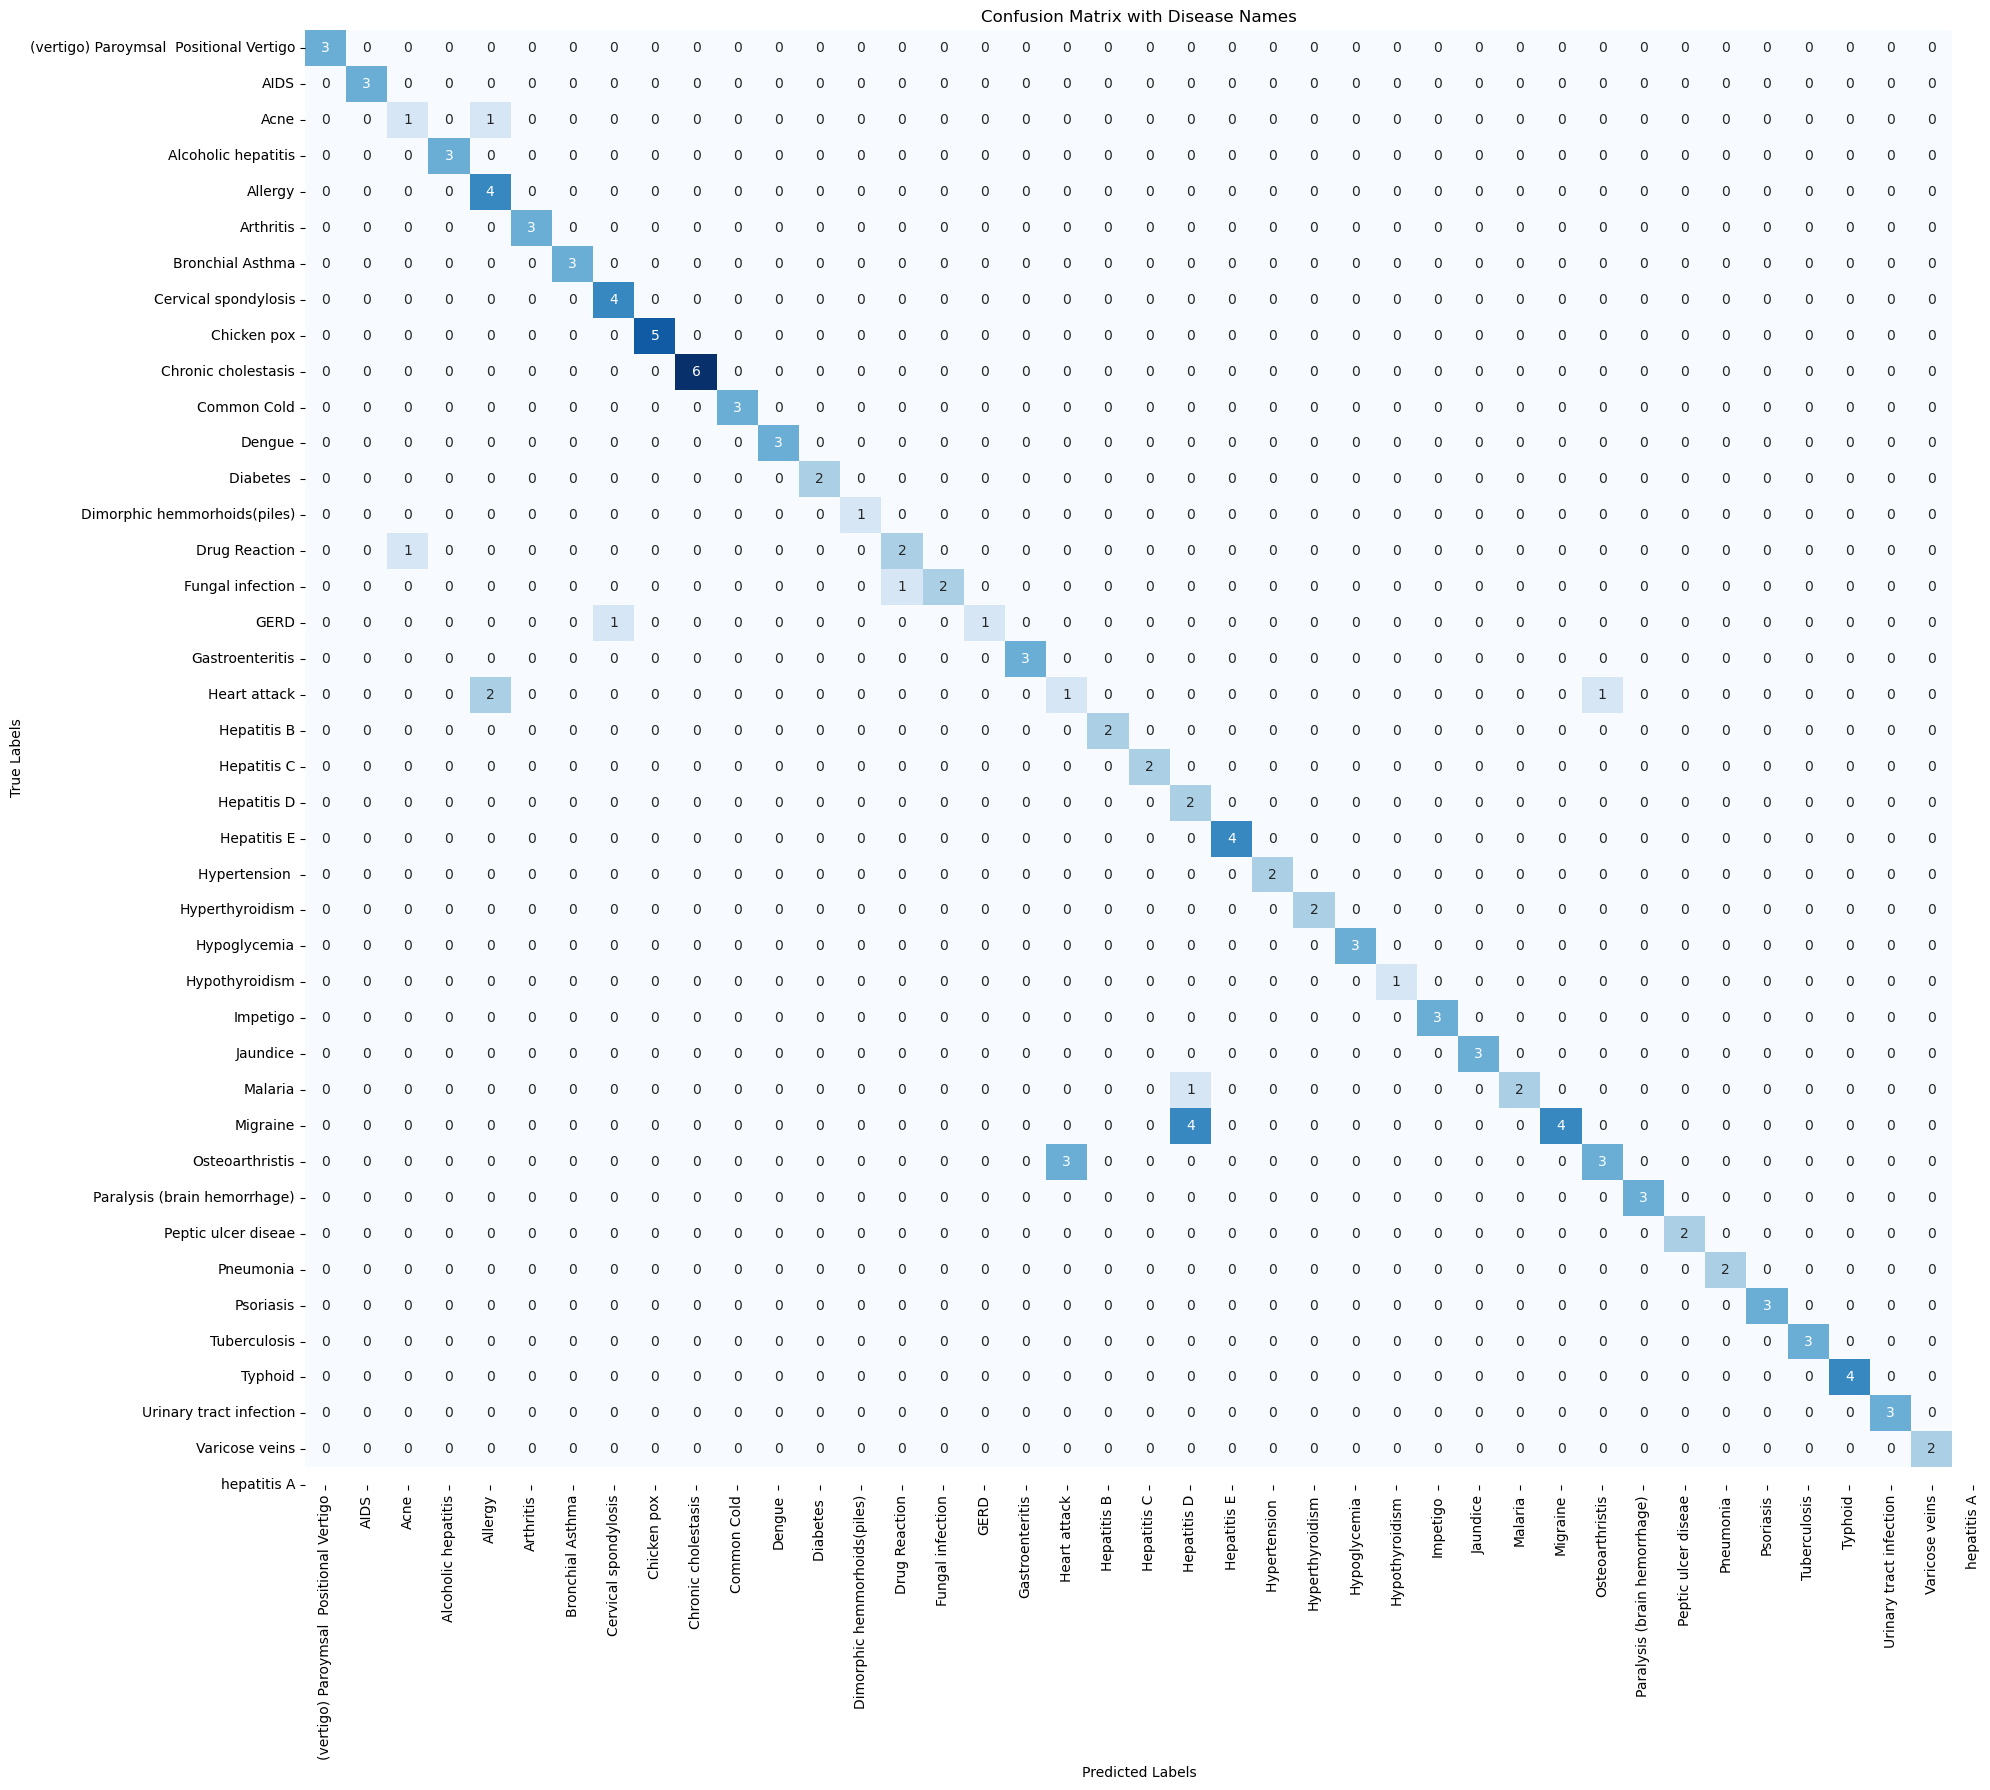

In [27]:
import json
conf_matrix = confusion_matrix(y_test, y_pred)

with open("../data/processed/disease_mapping.json", "r") as f:
    disease_mapping = json.load(f)
index_to_disease = {v: k for k, v in disease_mapping.items()}


plt.figure(figsize=(20, 18))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=[index_to_disease[i] for i in range(len(disease_mapping))],
            yticklabels=[index_to_disease[i] for i in range(len(disease_mapping))])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix with Disease Names")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [22]:
correct_predictions = np.trace(conf_matrix) #trace of the matrix is the sum of the diagonals
total_test_samples = len(y_test)
print(f"Number of correct predictions: {correct_predictions} out of {total_test_samples}")

Number of correct predictions: 108 out of 123


In [23]:
correct_predictions_simple = (y_pred == y_test).sum()
print(f"Number of correct predictions (simple method): {correct_predictions_simple} out of {total_test_samples}")

Number of correct predictions (simple method): 108 out of 123


In [17]:
import joblib

joblib.dump(voting_clf, "../src/models/voting_classifier_model.joblib")
print(f"Model saved as ../src/models/voting_classifier_model.joblib")

Model saved as ../src/models/voting_classifier_model.joblib
